# EDA of Clustering Method

In [23]:
fr
import pandas as pd
import numpy as np
import concurrent.futures as cf
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import nltk
import pickle
from glob import glob
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from collections import Counter
import altair as alt
from scipy import stats

pd.set_option('display.max_columns', None)

%matplotlib inline

In [ ]:
!conda install -c conda-forge kneed -y
from kneed import KneeLocator

## KMeans Overview

A partitioning type of clustering method
Main parameter is k, or, the number of clusters to group the data into
Nondeterministic, this means the algorithm could produce different resultz for two different iterations using the same dataset

**Strengths**
Scale well with large datasets

**Weaknesses**


With this algorithm we try to minimize the sum of squared Euclidean distances. In other words, we try to minimize inertia or make it so that the centroids move the least amount possible after each iteration (i.e. we seek convergeance or optimal spot for the cluster centroids).

Assumptions we are making.


Questions we are asking
What are the Characteristics of the clusters
Which cluster had the most amount of accuracy in terms of representing the same jobs in all three groups

## Getting and Preprocessing Data

In [136]:
path_in = '/Users/ramonperez/Dropbox/Burning Glass/Analysis/unsupervised_approach/'
models = path_in + 'models/kmeans/'

In [5]:
%%time

sample_name = 'km_text_approach_5k_2.csv'

df = pd.read_csv(path_in + sample_name, low_memory=False)
df.head()

CPU times: user 620 ms, sys: 107 ms, total: 727 ms
Wall time: 729 ms


,Language,CanonCity,CanonState,CleanJobTitle,JobDate,JobText,JobID,Latitude,Longitude,CanonPostalCode,CanonCounty,DivisionCode,LMA,MSA,CanonEmployer,CanonJobTitle,ConsolidatedONET,CanonIntermediary,InternshipFlag,Source,CanonSkillClusters,CanonSkills,IsDuplicate,CanonMinimumDegree,CanonRequiredDegrees,CIPCode,MinExperience,ConsolidatedInferredNAICS,BGTOcc,MaxAnnualSalary,MaxHourlySalary,MinAnnualSalary,MinHourlySalary,CanonJobHours,CanonJobType,CanonYearsOfExperienceCanonLevel,CanonYearsOfExperienceLevel,ConsolidatedDegreeLevels,ConsolidatedTitle,MaxDegreeLevel,MinDegreeLevel,BGTSubOcc,YearsOfExperience,year,clean_text,charac_text_len,low_clean,list_job_text,list_title_words,len_job_text,normal_text,normal_titles,titles_uni_5,titles_bi_5,titles_tri_5,titles_uni_10,titles_bi_10,titles_tri_10,titles_uni_15,titles_bi_15,titles_tri_15,titles_uni_20,titles_bi_20,titles_tri_20,titles_uni_25,titles_bi_25,titles_tri_25,titles_uni_30,titles_bi_30,titles_tri_30,titles_uni_35,titles_bi_35,titles_tri_35,titles_uni_40,titles_bi_40,titles_tri_40,titles_uni_45,titles_bi_45,titles_tri_45,titles_uni_50,titles_bi_50,titles_tri_50,titles_uni_55,titles_bi_55,titles_tri_55,titles_uni_60,titles_bi_60,titles_tri_60,text_uni_5,text_bi_5,text_tri_5,text_uni_10,text_bi_10,text_tri_10,text_uni_15,text_bi_15,text_tri_15,text_uni_20,text_bi_20,text_tri_20,text_uni_25,text_bi_25,text_tri_25,text_uni_30,text_bi_30,text_tri_30,text_uni_35,text_bi_35,text_tri_35,text_uni_40,text_bi_40,text_tri_40,text_uni_45,text_bi_45,text_tri_45,text_uni_50,text_bi_50,text_tri_50,text_uni_55,text_bi_55,text_tri_55,text_uni_60,text_bi_60,text_tri_60
0,en,Sullivan,MO,Program Director,2017-12-22,2017-12-20 00:00:00\n\nProgram Director\n\nin ...,38312338220,38.2613,-91.1416,63080.0,Franklin,NaN,MT294118,41180: Metropolitan Statistical Area,Air Evac Lifeteam,NaN,11911100,NaN,0,Company,Specialized Skills|Public Safety and National ...,{'Building Effective Relationships': 'Speciali...,False,NaN,NaN,NaN,NaN,6219.0,11-9111.00,NaN,NaN,NaN,NaN,fulltime,permanent,NaN,NaN,NaN,Program Director,NaN,NaN,Healthcare Administrator,NaN,2017,2017-12-20 00:00:00 Program Director in Apply ...,3705,2017-12-20 00:00:00 program director in apply ...,"['2017-12-20', '00:00:00', 'Program', 'Directo...","['Program', 'Director']",506,20171220 000000 program director in apply with...,program director,1,1,1,8,1,6,5,1,1,6,3,3,11,18,6,11,13,18,32,13,2,1,13,2,31,13,17,31,1,17,54,12,7,47,12,1,2,0,0,4,7,2,0,7,9,4,11,7,1,10,18,27,10,28,34,6,33,16,9,18,16,9,26,28,38,26,14,32,30,1,17,27
1,en,Pembroke,NC,Center Store Grocery Manager,2020-05-09,FT Center Store (Grocery) Manager\n\nFood Lion...,38776667054,34.6813,-79.1947,28372.0,Robeson,NaN,MC373130,31300: Micropolitan Statistical Area,Food Lion Incorporated,Store Manager,41101100,NaN,0,Job Board,Finance: Budget Management;Specialized Skills|...,{'Budgeting': 'Finance: Budget Management;Spec...,False,Higher Secondary Certificate,NaN,NaN,NaN,445110.0,41-1011.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,Store Manager,12.0,12.0,Retail Store Manager,NaN,2020,FT Center Store (Grocery) Manager Food Lion - ...,5231,ft center store (grocery) manager food lion - ...,"['FT', 'Center', 'Store', '(Grocery)', 'Manage...","['Center', 'Store', 'Grocery', 'Manager']",764,ft center store grocery manager food lion pemb...,center store grocery manager,0,1,3,2,8,7,2,8,0,15,2,10,18,10,4,18,8,2,25,8,1,5,8,1,7,8,3,7,34,3,43,16,41,50,16,9,4,2,4,9,2,5,14,2,0,14,9,2,7,8,12,11,8,15,11,9,15,13,4,12,13,4,21,13,33,10,13,50,44,35,50,44
2,en,Greenbrae,CA,Travel Or Registered Nurse Operating Room Regi...,2020-07-19,Travel OR RN Operating Room RN at Focus Staff...,38817493592,37.8974,-122.5400,94904.0,Marin,42034.0,DV064188|MT064186,41860: Metropolitan Statistical Area|488: Comb...,Recruiting Agency,Operating Room Registered Nurse,29114100,Focus Staff,0,Job intermediary,Information Technology: Cybersecurity;Speciali...,{'Anomaly Detection': 'Information Technology:...,False,Associate's,Associate's,NaN,2.

In [6]:
df.shape

(5000, 124)

In [7]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 124 entries, Language to text_tri_60
dtypes: bool(1), float64(12), int64(77), object(34)
memory usage: 103.1 MB


In [ ]:
df.melt()

In [22]:
df.columns

Index(['Language', 'CanonCity', 'CanonState', 'CleanJobTitle', 'JobDate',
       'JobText', 'JobID', 'Latitude', 'Longitude', 'CanonPostalCode',
       ...
       'text_tri_45', 'text_uni_50', 'text_bi_50', 'text_tri_50',
       'text_uni_55', 'text_bi_55', 'text_tri_55', 'text_uni_60', 'text_bi_60',
       'text_tri_60'],
      dtype='object', length=124)

In [19]:
title_vars = list(df.columns[52:88])
len(title_vars), title_vars[:10]

(36,
 ['titles_uni_5',
  'titles_bi_5',
  'titles_tri_5',
  'titles_uni_10',
  'titles_bi_10',
  'titles_tri_10',
  'titles_uni_15',
  'titles_bi_15',
  'titles_tri_15',
  'titles_uni_20'])

In [21]:
jobtext_vars = list(df.columns[88:])
len(jobtext_vars), jobtext_vars[-10:]

(36,
 ['text_tri_45',
  'text_uni_50',
  'text_bi_50',
  'text_tri_50',
  'text_uni_55',
  'text_bi_55',
  'text_tri_55',
  'text_uni_60',
  'text_bi_60',
  'text_tri_60'])

## Section II - Titles Analysis

Load back the models, take the SSE and plot the elbow curve to determine where there is an okay tradeoff between error and number of clusters.

### Evaluation - Elbow Method

Write a for loop to open all of the models, append the sse to a list, close pkl files, and move along.

In [37]:
!ls ~/Dropbox/Burning\ Glass/Analysis/unsupervised_approach/models/kmeans/job_titles

bigrams  trigrams unigrams


In [48]:
full_path = paths_for_models + model_dirs[0] + 't*.pkl'
full_path

'~/Dropbox/Burning Glass/Analysis/unsupervised_approach/models/kmeans/job_titles/bigrams/t*.pkl'

In [68]:
paths_title_models = models + 'job_titles/'
model_dirs = ['unigrams', 'bigrams', 'trigrams']

In [85]:
test_files = glob(paths_for_models + model_dirs[0] + '/t*.pkl')
for i, m in enumerate(sorted(test_files)): print(i, m)

0 /Users/ramonperez/Dropbox/Burning Glass/Analysis/unsupervised_approach/models/kmeans/job_titles/unigrams/titles_uni_05.pkl
1 /Users/ramonperez/Dropbox/Burning Glass/Analysis/unsupervised_approach/models/kmeans/job_titles/unigrams/titles_uni_10.pkl
2 /Users/ramonperez/Dropbox/Burning Glass/Analysis/unsupervised_approach/models/kmeans/job_titles/unigrams/titles_uni_15.pkl
3 /Users/ramonperez/Dropbox/Burning Glass/Analysis/unsupervised_approach/models/kmeans/job_titles/unigrams/titles_uni_20.pkl
4 /Users/ramonperez/Dropbox/Burning Glass/Analysis/unsupervised_approach/models/kmeans/job_titles/unigrams/titles_uni_25.pkl
5 /Users/ramonperez/Dropbox/Burning Glass/Analysis/unsupervised_approach/models/kmeans/job_titles/unigrams/titles_uni_30.pkl
6 /Users/ramonperez/Dropbox/Burning Glass/Analysis/unsupervised_approach/models/kmeans/job_titles/unigrams/titles_uni_35.pkl
7 /Users/ramonperez/Dropbox/Burning Glass/Analysis/unsupervised_approach/models/kmeans/job_titles/unigrams/titles_uni_40.pkl


In [115]:
mdel = pickle.load(open(test_files[0], 'rb'))
print(type(mdel))

<class 'sklearn.cluster._kmeans.KMeans'>


In [122]:
from typing import List, Tuple

def get_models_sse(path: str, mfiles: List[str]) -> Tuple[List[float], List[float], List[float], 
                                                          List[KMeans], List[KMeans], List[KMeans]]:
    
    model_uni = []
    model_bi = []
    model_tri = []
    
    sse_uni = []
    sse_bi = []    
    sse_tri = []
    
    for i, model_dir in enumerate(mfiles):
        
        files = glob(path + model_dir + '/t*.pkl')
        
        for model in sorted(files):

            in_model = open(model, 'rb')
            loaded_model = pickle.load(in_model)
            if i == 0:
                sse_uni.append(loaded_model.inertia_)
                model_uni.append(loaded_model)
                
            elif i == 1:
                sse_bi.append(loaded_model.inertia_)
                model_bi.append(loaded_model)
                
            else:
                sse_tri.append(loaded_model.inertia_)
                model_tri.append(loaded_model)

            in_model.close()
    
    return sse_uni, sse_bi, sse_tri, model_uni, model_bi, model_tri

In [123]:
%%time

title_uni_sse, title_bi_sse, title_tri_sse, title_model_uni, title_model_bi, title_model_tri = get_models_sse(path=paths_for_models, mfiles=model_dirs)

CPU times: user 344 ms, sys: 1.09 s, total: 1.44 s
Wall time: 1.54 s


In [124]:
title_tri_sse

[769239.7195911653,
 747426.5601295687,
 733508.4746817308,
 724794.0430969252,
 720055.5831640179,
 710442.3884988466,
 704336.1176791125,
 698030.7830447087,
 693347.7276672273,
 690050.5622955797,
 687837.5254061372,
 682795.8616386217]

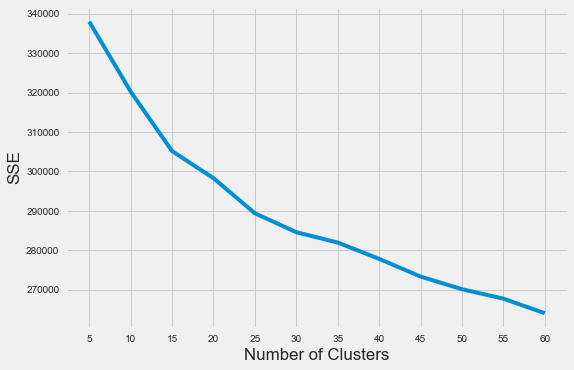

In [125]:
plt.style.use("fivethirtyeight")
plt.plot(range(5, 61, 5), title_uni_sse)
plt.xticks(range(5, 61, 5))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [126]:
from kneed import KneeLocator
kl = KneeLocator(range(5, 61, 5), title_tri_sse, curve='convex', direction='decreasing')
kl.elbow

30

In [166]:
from yellowbrick.cluster import KElbowVisualizer

# Generate synthetic dataset with 8 random clusters

# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(title_model_uni, k=(4,12))

visualizer.fit(X)        # Fit the data to the visualizer
# visualizer.show()  

Let's now look at the distribution of jobs within n_grams and clusters.

In [127]:
df[title_vars].describe()

,titles_uni_5,titles_bi_5,titles_tri_5,titles_uni_10,titles_bi_10,titles_tri_10,titles_uni_15,titles_bi_15,titles_tri_15,titles_uni_20,titles_bi_20,titles_tri_20,titles_uni_25,titles_bi_25,titles_tri_25,titles_uni_30,titles_bi_30,titles_tri_30,titles_uni_35,titles_bi_35,titles_tri_35,titles_uni_40,titles_bi_40,titles_tri_40,titles_uni_45,titles_bi_45,titles_tri_45,titles_uni_50,titles_bi_50,titles_tri_50,titles_uni_55,titles_bi_55,titles_tri_55,titles_uni_60,titles_bi_60,titles_tri_60
count,5000.000000,5000.000000,5000.000000,5000.0000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.252000,1.276600,1.272600,6.2286,2.365200,5.639800,5.858600,3.126600,4.230800,6.532200,5.251000,5.70300,8.032400,15.143000,8.035400,10.093600,13.336200,15.055800,21.309600,13.96340,10.303200,18.191000,14.979400,11.616600,26.345800,14.897600,16.285200,28.031200,14.641400,16.823800,22.241200,16.352800,19.050200,24.271400,18.249200,14.570200
std,0.954085,0.881276,0.884786,2.7578,2.557956,1.796859,3.354468,3.431053,4.352163,4.630643,6.136638,4.47741,7.466063,5.563555,5.357003,9.116834,6.601749,6.706719,12.663026,7.35212,11.419902,9.634619,9.166121,12.241862,15.828731,8.841445,9.388008,16.105332,16.307225,10.321553,14.492834,11.787066,16.032726,13.641428,14.198796,18.694132
min,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,5.0000,1.000000,6.000000,5.000000,1.000000,1.000000,4.000000,1.000000,3.00000,2.000000,13.000000,6.000000,2.000000,10.000000,11.000000,9.000000,12.00000,2.000000,12.000000,12.000000,2.000000,11.000000,12.000000,12.000000,12.000000,1.000000,12.000000,12.000000,12.000000,7.000000,16.000000,12.000000,1.000000
50%,1.000000,1.000000,1.000000,8.0000,1.000000,6.000000,5.000000,1.000000,1.000000,4.000000,1.000000,3.00000,4.000000,18.000000,6.000000,6.000000,13.000000,18.000000,25.000000,13.00000,2.000000,20.000000,13.000000,2.000000,28.000000,13.000000,17.000000,31.000000,1.000000,17.000000,19.000000,12.000000,7.000000,24.000000,12.000000,4.000000
75%,1.000000,1.000000,1.000000,8.0000,3.000000,6.000000,7.000000,5.000000,7.000000,9.000000,10.000000,10.00000,14.000000,18.000000,10.000000,18.000000,13.000000,18.000000,34.000000,15.00000,22.000000,23.000000,15.000000,23.000000,44.000000,16.000000,17.000000,44.000000,29.000000,17.000000,30.000000,16.000000,33.000000,30.000000,23.000000,25.000000
max,4.000000,4.000000,4.000000,9.0000,9.000000,9.000000,14.000000,14.000000,14.000000,19.000000,19.000000,19.00000,24.000000,24.000000,24.000000,29.000000,29.000000,29.000000,34.000000,34.00000,34.000000,39.000000,39.000000,39.000000,44.000000,44.000000,44.000000,49.000000,49.000000,48.000000,54.000000,53.000000,54.000000,59.000000,59.000000,59.000000


### Evaluation - Silhouette Coefficient

### Evaluation - Visual Eval of Clusters from different algorithms

In [128]:
# !conda install -c districtdatalabs yellowbrick -y

In [129]:
from yellowbrick.text import TSNEVisualizer

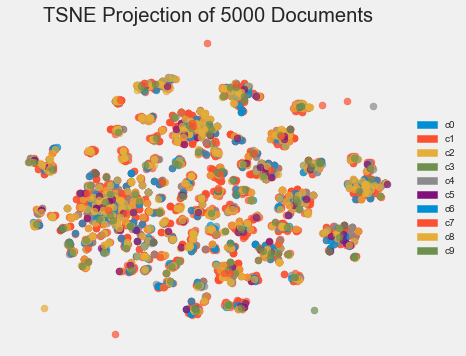

In [162]:
tsne = TSNEVisualizer()

count_vect_bi = CountVectorizer(ngram_range=(1, 2))
cv_titles_bi = count_vect_bi.fit_transform(df['CleanJobTitle'].values)

tsne.fit(cv_titles_bi, ["c{}".format(c) for c in title_model_bi[0].labels_])
tsne.poof();

## Section III - Job Descriptions Analysis

In [137]:
models

'/Users/ramonperez/Dropbox/Burning Glass/Analysis/unsupervised_approach/models/kmeans/'

In [153]:
!ls /Users/ramonperez/Dropbox/Burning\ Glass/Analysis/unsupervised_approach/models/kmeans/job_descriptions/

bigrams  trigrams unigrams


In [154]:
model_dirs

['unigrams', 'bigrams', 'trigrams']

In [155]:
paths_text_models = models + 'job_descriptions/'

In [156]:
%%time

jt_uni_sse, jt_bi_sse, jt_tri_sse, jt_model_uni, jt_model_bi, jt_model_tri = get_models_sse(path=paths_text_models, mfiles=model_dirs)

CPU times: user 93.1 ms, sys: 263 ms, total: 357 ms
Wall time: 534 ms


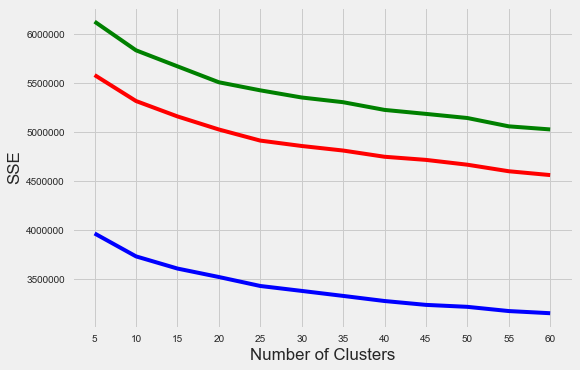

In [160]:
plt.plot(range(5, 61, 5), jt_uni_sse, color='blue')
plt.plot(range(5, 61, 5), jt_bi_sse, color='red')
plt.plot(range(5, 61, 5), jt_tri_sse, color='green')
plt.xticks(range(5, 61, 5))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [143]:
kl = KneeLocator(range(5, 61, 5), jt_bi_sse, curve='convex', direction='decreasing')
kl.elbow

25

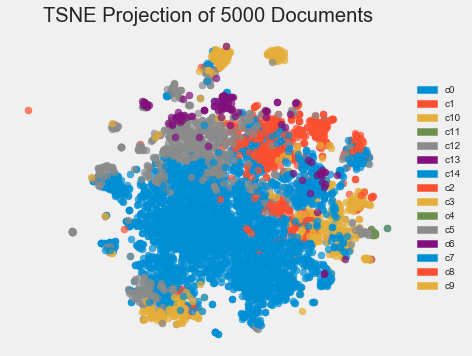

CPU times: user 2min 19s, sys: 3.29 s, total: 2min 22s
Wall time: 26.7 s


In [163]:
%%time

tsne = TSNEVisualizer()

count_vect_bi = CountVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.85)
cv_text_bi = count_vect_bi.fit_transform(df['normal_text'].values)

tsne.fit(cv_text_bi, ["c{}".format(c) for c in jt_model_bi[2].labels_])
tsne.poof();

In [169]:
jt_model_bi

[KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
        n_clusters=5, n_init=25, n_jobs=4, precompute_distances='auto',
        random_state=42, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
        n_clusters=10, n_init=25, n_jobs=4, precompute_distances='auto',
        random_state=42, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
        n_clusters=15, n_init=25, n_jobs=4, precompute_distances='auto',
        random_state=42, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
        n_clusters=20, n_init=25, n_jobs=4, precompute_distances='auto',
        random_state=42, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
        n_clusters=25, n_init=25, n_jobs=4, precompute_distances='auto',
        random_state=42, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', 

/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


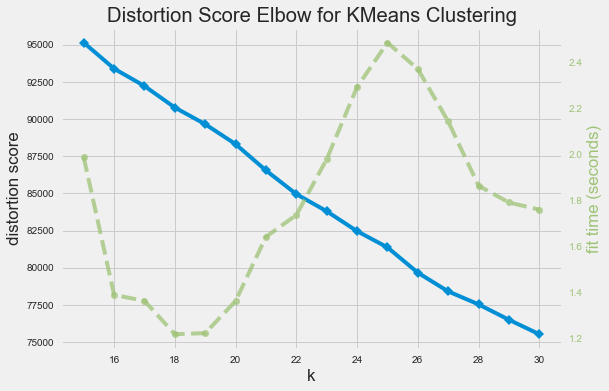

CPU times: user 1.36 s, sys: 242 ms, total: 1.6 s
Wall time: 29.4 s


In [171]:
%%time


from yellowbrick.cluster import KElbowVisualizer

# Generate synthetic dataset with 8 random clusters

km2 = KMeans(init='k-means++',
             n_init=15,
             max_iter=300,
             random_state=42,
             n_jobs=4)

cv_text_bi2 = count_vect_bi.fit_transform(df['normal_text'].sample(n=200).values)

# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(km2, k=np.arange(15, 31))

visualizer.fit(cv_text_bi2)        # Fit the data to the visualizer
visualizer.show()  

## Assessment of Other Jobs with known categories

Pick GitLab for example, scrape their org chart. If you can find one or more examples that would be great too
Using the best model, see if you can correctly cluster their job positions.

**Adjusted Rand Index** could help with cases such as this one when using ground truth values.

`LabelEncoder()` from sklearn would be helpful for creating cluster labels for the jobs. Use `.classes_` to see the classes generate and also check the lenght

Another way of testing the clustering algorithms is by creating a train and a test set. What you want to do here is to evaluate **prediction strength**. You could potentially test this with the companies dataset.

For non-deterministic clustering algorithms, such as k-means,
which can generate different clusterings depending on the initial
positions of centroids, it is recommended to do multiple runs
of the clustering algorithm for the same k and compute the average
prediction strength ¯ ps(k) over multiple runs.

Another effective method to estimate the number of clusters is the gap statistic method.
Other, less automatic methods, which some analysts still use, include the elbow method and
the average silhouette method.


KNN might be useful to find out the nearest neighbors to those with a **true_label** and see whether it maps